In [10]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Load Data

In [11]:
K=3
mnist = tf.keras.datasets.mnist

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [13]:
x_train.shape

(60000, 28, 28)

In [14]:
# 假设 x_trn 是 (N, d) 形状的二维数据集
# 100 个train，10个test
# 先随机选择 100 个样本的索引
indices = np.random.choice(x_train.shape[0], 10000, replace=False)

# 使用这些索引来选择对应的数据
x_trn = x_train[indices]
y_trn = y_train[indices]

indices = np.random.choice(x_test.shape[0], 100, replace=False)

# 使用这些索引来选择对应的数据
x_tst = x_test[indices]
y_tst = y_test[indices]

### Calculate Exact SV

In [15]:
def get_true_KNN(x_trn, x_tst):
    N = x_trn.shape[0]
    N_tst = x_tst.shape[0]
    x_tst_knn_gt = np.zeros((N_tst, N))
    for i_tst in tqdm(range(N_tst)):
        dist_gt = np.zeros(N)
        for i_trn in range(N):  
            dist_gt[i_trn] = np.linalg.norm(x_trn[i_trn, :] - x_tst[i_tst, :], 2)
        x_tst_knn_gt[i_tst, :] = np.argsort(dist_gt)
    return x_tst_knn_gt.astype(int)


def compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, K):
    N = x_trn.shape[0]
    N_tst = x_tst_knn_gt.shape[0]
    sp_gt = np.zeros((N_tst, N))
    for j in tqdm(range(N_tst)):
        sp_gt[j, x_tst_knn_gt[j, -1]] = (y_trn[x_tst_knn_gt[j, -1]] == y_tst[j]) / N
        for i in np.arange(N - 2, -1, -1):
            sp_gt[j, x_tst_knn_gt[j, i]] = sp_gt[j, x_tst_knn_gt[j, i + 1]] + \
                                           (int(y_trn[x_tst_knn_gt[j, i]] == y_tst[j]) -
                                            int(y_trn[x_tst_knn_gt[j, i + 1]] == y_tst[j])) / K * min([K, i + 1]) / (
                                                       i + 1)
    return sp_gt


In [16]:
x_tst_knn_gt = get_true_KNN(x_trn,x_tst)

100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


In [17]:
sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, K)

100%|██████████| 100/100 [00:04<00:00, 20.74it/s]


(100, 10000)


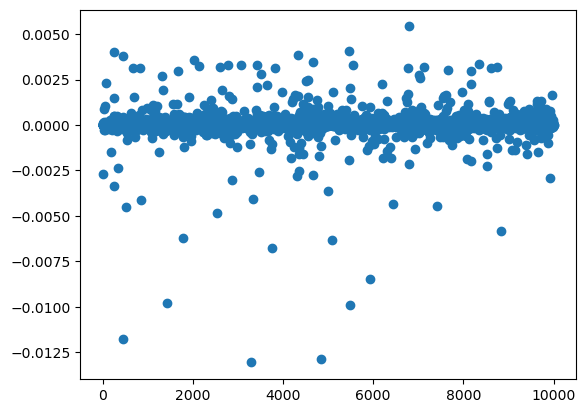

In [18]:
print(sp_gt.shape)
plt.scatter(range(sp_gt.shape[1]),np.mean(sp_gt,0))

### 开始LSH Approximation SV

### Improved MC Approximation

In [19]:
class Heap:
    def __init__(self,K,dist):
        self.K=K
        self.counter = -1
        self.heap = []
        self.changed = 0
        self.dist = dist
        self.heap_dist = {}

    def insert(self,a):
        dist_a = self.dist(a)
        # if a == 11:
        #     pdb.set_trace()
        if self.counter <= self.K-2:
            self.heap.append(a)
            self.heap_dist[a] = dist_a
            self.counter += 1
            self.up(self.counter)
            self.changed = 1
        else:
            if dist_a < self.dist(self.heap[0]):
                self.heap[0] = a
                self.heap_dist[a] = dist_a
                self.down(0)
                self.changed = 1
            else:
                self.changed = 0

    def up(self,index):
        if index == 0:
            return
        parent_index = (index-1)//2
        if self.dist(self.heap[index]) > self.dist(self.heap[parent_index]):
            self.heap[index],self.heap[parent_index] = self.heap[parent_index],self.heap[index]
            self.up(parent_index)
        return

    def down(self,index):
        if 2*index + 1 > self.counter:
            return
        if 2*index + 1 < self.counter:
            if self.dist(self.heap[2*index + 1]) < self.dist(self.heap[2*index + 2]):
                tar_index = 2*index + 2
            else:
                tar_index = 2*index + 1
        else:
            tar_index = 2*index + 1
        if self.dist(self.heap[index]) < self.dist(self.heap[tar_index]):
            self.heap[index],self.heap[tar_index] = self.heap[tar_index],self.heap[index]
            self.down(tar_index)
        return


In [20]:
def knn_mc_approximation(x_trn,y_trn,x_tst,y_tst,K,T):
    '''
    :param x_trn: training data
    :param y_trn: training label
    :param x_tst: test data
    :param y_tst: test label
    :param utility: utility function that maps a set of training instances to its utility
    :param T: the number of permutations
    :return: estimate of shapley value
    '''

    n_trn = x_trn.shape[0]
    n_tst = x_tst.shape[0]
    sp_approx_all = np.zeros((n_tst, T, n_trn))
    sp_approx =  np.zeros((n_tst, n_trn))
    for n_tst_i in range(n_tst):
        dist = lambda a: np.linalg.norm(x_trn[a,:]-x_tst[n_tst_i,:],ord=2)
        for t in range(T):
            value_now = np.zeros(n_trn)
            perm = np.random.permutation(np.arange(n_trn))  # data[t,:]
            heap = Heap(K=K,dist=dist)
            for k in range(n_trn):
                heap.insert(perm[k])
                # if heap.changed == 1:
                #     trn_dist = np.array([heap.heap_dist[key] for key in heap.heap[:(heap.counter+1)]])
                #     value_now[k] = utility(y_trn[heap.heap[:(heap.counter+1)]], y_tst[n_tst_i], trn_dist)
                # else:
                #     value_now[k] = value_now[k-1]
                if heap.changed == 1:
                    value_now[k] = utility_function(y_trn[heap.heap[:(heap.counter + 1)]],
                                                                         y_tst[n_tst_i], K)
                else:
                    value_now[k] = value_now[k-1]
            # compute the marginal contribution of k-th user's data
            sp_approx_all[n_tst_i, t, perm[0]] = value_now[0]
            sp_approx_all[n_tst_i, t, perm[1:]] = value_now[1:] - value_now[0:-1]
            if t % 100 == 0:
                print('%s out of %s' % (t, T))
        sp_approx[n_tst_i,:] = np.mean(sp_approx_all[n_tst_i, :, :], axis=0)
    return sp_approx

# 示例效用函数 (简单和作为示例)
def utility_function(y_trn,y_tst,K):
        # x_tst is a single test point
    utility = np.sum((y_trn==y_tst))/K
    return utility

In [21]:
# 测试
T = 100   # 假设的排列次数
sp = knn_mc_approximation(x_trn,y_trn,x_tst,y_tst,K,T)

0 out of 100
0 out of 100


KeyboardInterrupt: 

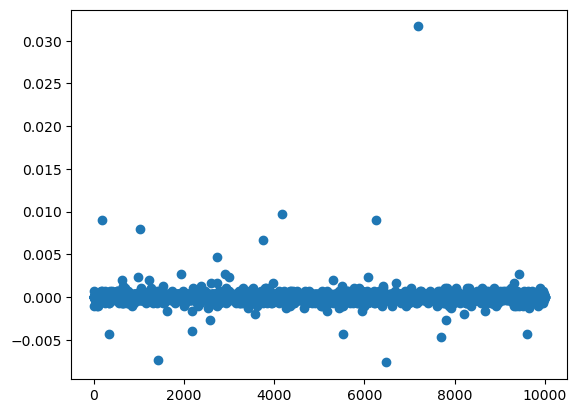

In [13]:
plt.scatter(range(sp.shape[1]),np.mean(sp,0))